In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
from utiles import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import cohen_kappa_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class DataHandler:
    class __DataHandler:
        path = None
        datos = {}
        
        def __init__(self, path):
            self.path = path
        def __str__(self):
            return repr(self) + self.path

        def get_data(self, una_bolsa, one_row=True):
            if una_bolsa in self.datos.keys():
                return self.return_data(una_bolsa, one_row)

            return self.load_data(una_bolsa, one_row)
        
        def return_data(self, una_bolsa, one_row=False):
            bolsa = pd.DataFrame([])
            keys = self.datos[una_bolsa].keys()
            for k in keys:
                df = self.datos[una_bolsa][k]
#                 if one_row:
#                     df = pd.DataFrame(df.values.reshape(1, -1))
                bolsa = pd.concat([bolsa, df], ignore_index=True)
            return bolsa
        
        
        def load_data(self, una_bolsa, one_row=False):
            sets = os.listdir(self.path+"/"+una_bolsa)
            if len(sets) != 0:
                self.datos[una_bolsa] = {}
                for s in sets:
                    ruta = "{}/{}/{}".format( self.path, una_bolsa, s)
                    df = pd.read_csv(ruta, index_col=[0], names=["amp"]).T
                    self.datos[una_bolsa][s] = df
                return self.return_data(una_bolsa, one_row)
            print("Error!: No existe la bolsa especificada")
            return
        
        def get_all(self, one_row=True):
            total_data = pd.DataFrame()
            for i, k in enumerate(self.datos.keys()):
                df = self.return_data(k, one_row)
                df["clase"] = k
                total_data = pd.concat([total_data, df], ignore_index=True)
            return total_data
        
        def load_all(self):
            if self.path:
                bolsas = [x.name for x in os.scandir(self.path) if os.path.isdir(x)]
                for b in bolsas:
                    self.load_data(b)
            else:
                print("Path undefined")

        
    instance = None
    def __init__(self, path):
        if not DataHandler.instance:
            DataHandler.instance = DataHandler.__DataHandler(path)
        else:
            DataHandler.instance.path = path
    def __getattr__(self, name):
        return getattr(self.instance, name)

In [3]:
loader = DataHandler("data")
loader.load_all()
data = loader.get_all()

In [4]:
std = StandardScaler()
data['n_clase'] = np.where(data['clase']=='sin adulterar', 0, 1)
normalized = std.fit_transform(data.iloc[:,:-2])

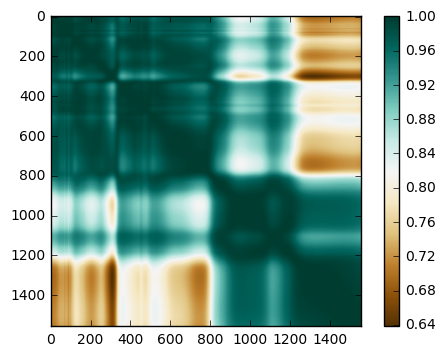

In [5]:
cor_data = pd.DataFrame(normalized).corr()

fig = plt.figure()
plt.imshow(cor_data, interpolation="nearest", cmap=plt.cm.BrBG)
plt.colorbar()
plt.show()

In [6]:
# scatter_matrix(data.iloc[:,:4], alpha=0.2, figsize=(8, 8), diagonal='kde')

In [7]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(data["clase"])
# clases = le.transform(data["clase"])

# le.transform(["sin adulterar"])

In [8]:
data['n_clase'] = np.where(data['clase']=='sin adulterar', 0, 1)
X_train, X_test, y_train, y_test = train_test_split(normalized, data["n_clase"], test_size=.3, random_state=10)

model = LogisticRegression()# create the RFE model and select 10 from 1557 attributes
rfe = RFE(model, 10, step=10)
rfe = rfe.fit(X_train, y_train)
print(rfe.ranking_)

[61 78 95 ..., 51 53 55]


In [9]:
# indices = np.where(rfe.ranking_==1)   # Rank of each feature. 1 means the feature was selected
indices = np.where(rfe.support_)
new_data = normalized[:, indices[0]]
print("shape of new_data: {}".format(new_data.shape))

shape of new_data: (566, 10)


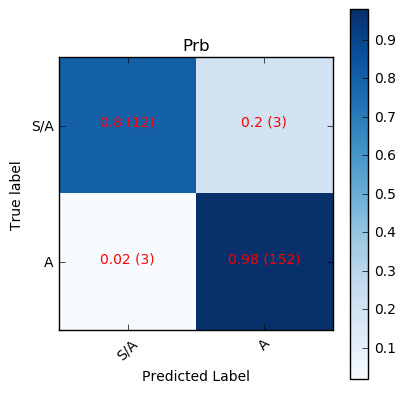

[ 0.99056604  0.98564593  0.96039604  0.96551724  0.97674419]


0.78064516129032258

In [10]:
from sklearn.ensemble import RandomForestClassifier
# clf = ExtraTreesClassifier(max_depth=6, n_jobs=4, n_estimators=20)
clf = RandomForestClassifier(max_depth=6, n_jobs=4, n_estimators=20, criterion="gini")
clf.fit(X_train[:, indices[0]], y_train)
p = clf.predict(X_test[:, indices[0]])
cm = confusion_matrix(y_pred=p, y_true=y_test)

plot_confusion_matrix(classes=["S/A", "A"], cm=cm, norm=True, title="Prb")
val = cross_val_score(estimator=clf, X=normalized[:, indices[0]], y=data["n_clase"], n_jobs=4, scoring="f1", cv=5)
print(val)
cohen_kappa_score(y_test, p)

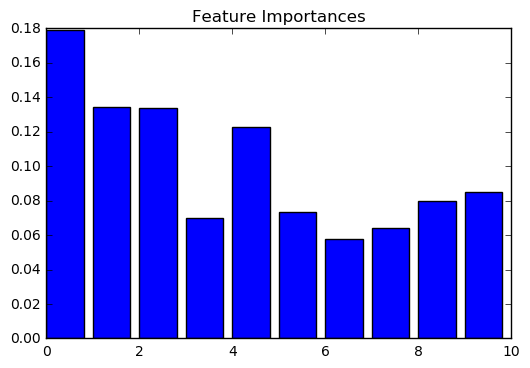

In [ ]:
f = plt.figure()
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.show()

## Intentando hacer lo mismo con todas las clases

Detectando 'sudan 4 - 5%'


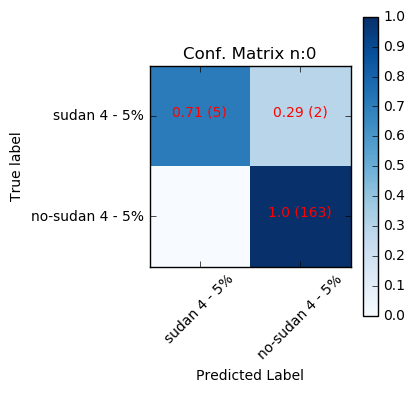

[ 0.98604651  0.97674419  0.99047619  0.95145631  0.98591549]
Kappa's Cohen test: 0.8274111675126903





Detectando 'sudan 4 - 2,5%'


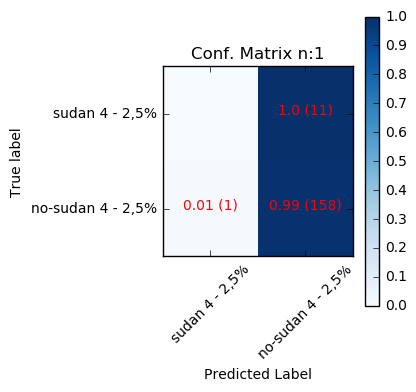

[ 0.92380952  0.96330275  0.96330275  0.96330275  0.95852535]
Kappa's Cohen test: -0.01090188305252715





Detectando 'sudan 2 - 2,5%'


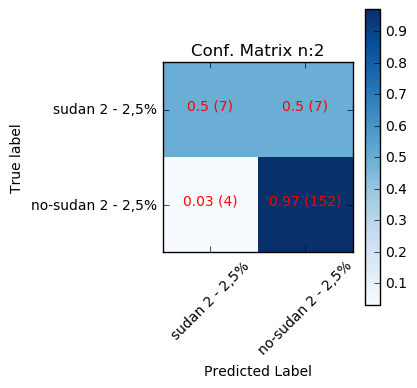

[ 0.95283019  0.96226415  0.96774194  0.97222222  0.97222222]
Kappa's Cohen test: 0.5256215119228818





Detectando 'sudan 4 - 1%'


In [ ]:
for i, c in enumerate(loader.datos.keys()):
    print("Detectando '{}'".format(c))
    model = LogisticRegression()
    # create the RFE model to select 30 of 1557 attributes
    rfe = RFE(model, 20, step=10)
    data['n_clase'] = np.where(data['clase']==c, 0, 1)

    X_train, X_test, y_train, y_test = train_test_split(normalized, data["n_clase"], test_size=.3, random_state=10)
 
    rfe = rfe.fit(X_train, y_train)

    indices = np.where(rfe.support_)   # Rank of each feature. 1 means the feature was selected
    new_data = normalized[:, indices[0]]
    
#     clf = ExtraTreesClassifier(max_depth=4, n_jobs=4, n_estimators=20)
    clf = RandomForestClassifier(max_depth=6, n_jobs=4, n_estimators=20, criterion="gini")
    clf.fit(X_train[:, indices[0]], y_train)
    p = clf.predict(X_test[:, indices[0]])
    cm = confusion_matrix(y_pred=p, y_true=y_test)

    plot_confusion_matrix(classes=[c, "no-{}".format(c)], cm=cm, norm=True, title="Conf. Matrix n:{}".format(i) )
    val = cross_val_score(estimator=clf, X=new_data, y=data["n_clase"], n_jobs=4, scoring="f1", cv=5)
    print(val)
    print("Kappa's Cohen test: {}".format(cohen_kappa_score(y_test, p)))
    print("\n\n\n\n")